In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statistics import *
import heartpy as hp
import copy
pd.options.display.max_rows = 450

patPWV = pd.read_csv("PWVbyPatient.csv", header=None)

In [2]:
#Helper Methods

def segmentProcess1(data, sample_rate=240.0):
    # Change values ouside possible range to min and max pulse value
    data = [0 if i <= 0 else (550 if i > 550 else i) for i in data]
    data = hp.filter_signal(data, cutoff=15, sample_rate=sample_rate, order=4, filtertype='lowpass')
    data = hp.filter_signal(data, cutoff=.01, sample_rate=sample_rate, order=4, filtertype='highpass')
    wd, m = hp.process(hrdata=data, sample_rate=sample_rate, bpmmin=0, bpmmax=550)
    return wd, m

def segmentProcess2(peakList, sample_rate=240.0):
    test = []
    # test.append(0)
    try:
        peakList.insert(0, 0)
    except:
        peakList = np.insert(peakList, 0, 0)
    
    for i in range(len(peakList)-2):
        a = (peakList[i] + peakList[i+1])/2
        b = (peakList[i+1] + peakList[i+2])/2
        interval = .15*(b-a)
        a += interval
        b -= interval
        test.append(round(a))
        # test.append(round(b))
    return test

In [3]:
iter = 20
wds = []
rngs = []
df = pd.DataFrame()

for d in range(iter):
    if(d+1 < 10):
        fileStr = '0' + str(d+1)
    else:
        fileStr = str(d+1)
    data = hp.get_data('Data/Raw Data/Multiple Cath/X0' + fileStr + '.txt', delim = ' ', column_name = 'AO')
    wd, _ = segmentProcess1(data)
    df1 = pd.DataFrame(wd['hr'])
    df = pd.concat([df,df1], axis=1)
    wds.append(wd['peaklist'].copy())
for i in range(iter):
    if(i+1 < 10):
        fileStr = '0' + str(i+1)
    else:
        fileStr = str(i+1)
    rngs.append(segmentProcess2(wds[i]))

/home/anrath/miniconda3/envs/biopeaks/lib/python3.7/site-packages/numpy/ma/core.py:5240: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/anrath/miniconda3/envs/biopeaks/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


In [4]:
def calcStats(wave):
    #calculate metrics for each indexed wave saved in individual metric arrays
    #remove outliers, save only mean for each metric
    #append metric means to new df

    #finding maximum, defining region for dic notch
    sysMaxi = wave.idxmax()
    reg = wave[int(round(sysMaxi*1.05)):int(round(sysMaxi+(len(wave)*.28)))]
    diff = reg.diff()

    NP = [0,0]


    #find dic notch
    ser = [0,0]
    counter = 0
    for index,value in diff.items():
        if value < 1:
            counter = counter + 1
        if value >= 0:
            if counter > 0 and counter > ser[1]:
                ser[0] = index
                ser[1] = counter
            counter = 0



    #if no dic notch found:
    try:
        if ser[0] == 0 or ser[1] < len(reg)*.05:
            #estimate diastolic pressure as flattest point -> highest diff
            #range for diastolic pressure:
            diaReg = diff.tail(n=round(len(diff)*.9))
            diaP = diaReg.idxmax()
            dicN = round(mean([diaReg.idxmax(),diaReg.idxmin()]))
            #print("NO DIC NOTCH FOUND, estimating...")
        else:
            dicN = ser[0]
            if round(2*sysMaxi) > dicN+1:
                diaP = wave[dicN+1:round(2*sysMaxi)].idxmax()
            else:
                diaP = dicN+1
    except:
        return


    NP[0] = dicN
    NP[1] = diaP

    #saving dic notch and diastolic pressure for functions
    dicNotch = NP[0]
    diaP = NP[1]

    #beginning and end of wave
    beg = 0
    end = wave.last_valid_index()
    sysMaxi = wave.idxmax()


    #add calculated metrics to lists
    pp_pres.append(np.sum(wave))
    avg_sys_rise.append(wave[beg:sysMaxi].mean())
    sys_rise_area.append(sum(wave[beg:sysMaxi]))
    t_sys_rise.append(sysMaxi)
    avg_dec.append(wave[sysMaxi:end].mean())
    t_dec.append(end - sysMaxi)
    dec_area.append(np.sum(wave[sysMaxi:end]))
    avg_sys.append(wave[beg:dicNotch].mean())
    slope_sys.append((wave[dicNotch] - wave[beg]) / dicNotch)
    sys_area.append(sum(wave[beg:dicNotch]))
    t_sys.append(dicNotch)
    avg_sys_dec.append(wave[sysMaxi:dicNotch].mean())
    dn_sys.append(wave[sysMaxi] - wave[dicNotch])
    sys_dec_area.append(np.sum(wave[sysMaxi:dicNotch]))
    t_sys_dec.append(dicNotch - sysMaxi)
    avg_sys_dec_nodia.append(wave[sysMaxi:dicNotch].mean() - wave[diaP])
    avg_sys_nodia.append(wave[beg:dicNotch].mean() - wave[diaP])
    avg_sys_rise_nodia.append(wave[beg:sysMaxi].mean() - wave[diaP])
    avg_dec_nodia.append(wave[sysMaxi:end].mean() - wave[diaP])
    slope_dia.append((wave[end] - wave[dicNotch]) / (end - dicNotch))
    t_dia.append(end - dicNotch)
    avg_dia.append(wave[dicNotch:end].mean())
    dn_dia.append(wave[diaP] - wave[dicNotch])

In [5]:
metrics = []

for j in range(len(wds)):
    pp_pres = []
    avg_sys_rise = []
    sys_rise_area = []
    t_sys_rise = []
    avg_dec = []
    t_dec = []
    dec_area = []
    avg_sys = []
    slope_sys = []
    sys_area = []
    t_sys = []
    avg_sys_dec = []
    dn_sys = []
    sys_dec_area = []
    t_sys_dec = []
    avg_sys_dec_nodia = []
    avg_sys_nodia = []
    avg_sys_rise_nodia = []
    avg_dec_nodia = []
    slope_dia = []
    t_dia = []
    avg_dia = []
    dn_dia = []

    for i in range(len(rngs[j])-1):
        # print("{a} {b}".format(a=j, b=i))
        lowerB = rngs[j][i]
        upperB = rngs[j][i+1]
        wave = df.iloc[lowerB:upperB,j].reset_index(drop=True)
        calcStats(wave)
    metrics.append([pp_pres,avg_sys_rise,sys_rise_area,t_sys_rise,avg_dec,t_dec,dec_area,avg_sys,slope_sys,sys_area,t_sys,avg_sys_dec,dn_sys,sys_dec_area,t_sys_dec,avg_sys_dec_nodia,avg_sys_nodia,avg_sys_rise_nodia,avg_dec_nodia,slope_dia,t_dia,avg_dia,dn_dia,avg_sys_nodia])

## Testing signal comp methods

In [6]:
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from fastdtw import fastdtw
 
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift &lt; 0 means that y starts 'shift' time steps before x # shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift




In [55]:
from scipy.spatial.distance import euclidean

cc = []
# shift = []
ds = []
# paths = []

for pat in range(len(metrics)):
    try:
        cc[pat-1] = [i/max(cc[pat-1]) for i in cc[pat-1]]
        ds[pat-1] = [i/max(ds[pat-1]) for i in ds[pat-1]]
    except:
        pass
    cc.append([])
    ds.append([])
    for i in range(len(metrics)):
        a = wds[pat]
        b = wds[i]
        if(len(a) > len(b)):
            a = a[:len(b)]
        else:
            b = b[:len(a)]
        cc[pat].append(mean(cross_correlation_using_fft(a, b)))
        # shift.append(compute_shift(a, b))

        d, path = fastdtw(a, b, dist=euclidean)
        ds[pat].append(d)
        # paths.append(path)


In [56]:
ds[1]

[7.504750719444955e-05,
 0.0,
 0.002607104976704974,
 2.3138077743445333e-05,
 4.029576076794616e-05,
 0.0021796803146778574,
 0.004299080630845359,
 1.1474820381125695e-05,
 1.8724685289166216e-05,
 0.005729029703767644,
 0.00010038732229710829,
 0.06652517694108562,
 0.0009262272689833274,
 1.0,
 1.2486429438061582e-05,
 0.00011034472909283016,
 0.00032015443104850354,
 0.0003085010914220362,
 0.0021379365644754733,
 0.0003962631359791505]

In [57]:
cc[1]

[0.005336781506573342,
 0.028307366137271923,
 0.008335167484661619,
 1.505278811841619e-06,
 2.236189236657565e-06,
 0.014080111906720474,
 0.02208962141912831,
 4.754644019095736e-06,
 2.1878219652274656e-06,
 0.007523664679285498,
 5.905780495409968e-05,
 0.0937948994061076,
 0.001220571917342455,
 1.0,
 8.552545665004645e-06,
 7.734851374002058e-05,
 0.0009946431333891406,
 0.0311288365458745,
 0.012724549284064626,
 0.009262172907136308]

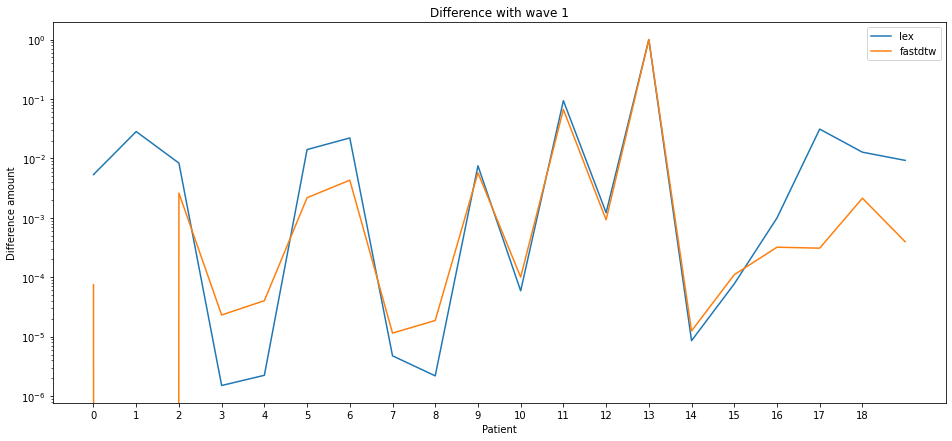

In [58]:
plt.figure(figsize=(16,7))
y1=cc[1]
y2=ds[1]
x=range(len(cc[1]))

plt.plot(x, y1, label = "lex")
plt.plot(x, y2, label = "fastdtw")
plt.legend()
plt.yscale('log')
plt.xlabel("Patient")
plt.ylabel("Difference amount")
plt.title("Difference with wave 1")
t = plt.xticks(np.arange(0, 19, 1.0))

# Other

In [71]:
# Removing the Outliers
for pat in range(len(metrics)):
    for feat in range(len(metrics[pat])):
        Q1 = np.percentile(metrics[pat][feat], 25, interpolation = 'midpoint') 
        Q3 = np.percentile(metrics[pat][feat], 75, interpolation = 'midpoint') 
        IQR = Q3 - Q1 

        # Removing the Outliers -- doesn't do much since the IQR is massive
        [value if value < (Q3+1.5*IQR) and value > (Q1-1.5*IQR) else metrics[pat][feat].remove(value) for value in metrics[pat][feat]]

In [84]:
import pandas as pd
# df = pd.DataFrame(metrics[0])
# df.transpose()
for i in range(len(metrics)):
    df = pd.DataFrame(metrics[i]).transpose()
    df.columns = ['pp_pres', 'avg_sys_rise', 'sys_rise_area', 't_sys_rise', 'avg_dec', 't_dec', 'dec_area', 'avg_sys', 'slope_sys', 'sys_area', 't_sys', 'avg_sys_dec', 'dn_sys', 'sys_dec_area', 't_sys_dec', 'avg_sys_dec_nodia', 'avg_sys_nodia', 'avg_sys_rise_nodia', 'avg_dec_nodia', 'slope_dia', 't_dia', 'avg_dia', 'dn_dia', 'avg_sys_nodia']
    df.to_csv('Data/' + str(i) + '.csv')
# df.to_csv('test.csv', index=False, header=True)

### Metrics is a list of patients. Each patient list has a list of features. Each list of features has values for each wave calculated.


# Testing

In [70]:
m1 = metrics
p1 = m1[0][0] # pp_pres
print(p1)

[747.9985753612459, 701.9988525102765, 949.1895343171803, 1216.8197683863107, 1427.943680287792, -68.11473695005537, -100.96148525668232, -242.20720207041805, 643.2679955417124, 874.4768197162698, 1075.1806494679963, -554.0812305197215, 983.5539147392105, 637.2993091341095, 408.6731485160546, 157.6934774352369, -500.0126668835637, -315.38401608217157, -962.6020013386296, -1452.3104496455571, -2249.1804540886915, -443.6187084243329, -960.5805979544274, -124.13731766760536, -1214.952741409635, -1496.2772507139027, 1084.1813297076046, 127.86769925579938, -815.1255833558286, -222.16399935664901, -1131.5122748943938, -1019.6104255829086, -1075.8346123991269, -1609.9854341408227, -721.1043637941746, -155.0053697551138, -777.3913025738946, 315.9312921578095, -240.9043800034042, -602.509795894057, -626.8549065883017, -429.2697960017021, -318.05651312881616, -250.4686793025538, -368.22159697047397, -363.5123046658689, -284.4510018795442, -279.85510537819073, -236.30081488573404, -262.5258943750

In [26]:
for i in range(len(rngs[0])-1):
    lowerB = rngs[0][i]
    upperB = rngs[0][i+1]

    # wave = wds[0]['hr'][lowerB:upperB]
    # wave = pd.DataFrame(wave)
    # calcStats(wave)
    wave = patPWV.iloc[lowerB:upperB,0].reset_index(drop=True)
    sysMaxi = wave.idxmax()
    reg = wave[int(round(sysMaxi*1.05)):int(round(sysMaxi+(len(wave)*.28)))]
    diff = reg.diff()

    NP = [0,0]

    #find dic notch
    ser = [0,0]
    counter = 0
    for index,value in diff.items():
        if value < 1:
            counter = counter + 1
        if value >= 0:
            if counter > 0 and counter > ser[1]:
                ser[0] = index
                ser[1] = counter
            counter = 0
    
    

    
    #if no dic notch found:
    try:
        if ser[0] == 0 or ser[1] < len(reg)*.05:
            #estimate diastolic pressure as flattest point -> highest diff
            #range for diastolic pressure:
            diaReg = diff.tail(n=round(len(diff)*.9))
            diaP = diaReg.idxmax()
            dicN = round(mean([diaReg.idxmax(),diaReg.idxmin()]))
            #print("NO DIC NOTCH FOUND, estimating...")
        else:
            dicN = ser[0]
            if round(2*sysMaxi) > dicN+1:
                diaP = wave[dicN+1:round(2*sysMaxi)].idxmax()
            else:
                diaP = dicN+1
    except:
        continue

    NP[0] = dicN
    NP[1] = diaP


    #saving dic notch and diastolic pressure for functions
    dicNotch = NP[0]
    diaP = NP[1]
    
    #beginning and end of wave
    beg = 0
    end = wave.last_valid_index()
    sysMaxi = wave.idxmax()
    

    #add calculated metrics to lists
    pp_pres.append(np.sum(wave))
    avg_sys_rise.append(wave[beg:sysMaxi].mean())
    sys_rise_area.append(sum(wave[beg:sysMaxi]))
    t_sys_rise.append(sysMaxi)
    avg_dec.append(wave[sysMaxi:end].mean())
    t_dec.append(end - sysMaxi)
    dec_area.append(np.sum(wave[sysMaxi:end]))
    avg_sys.append(wave[beg:dicNotch].mean())
    slope_sys.append((wave[dicNotch] - wave[beg]) / dicNotch)
    sys_area.append(sum(wave[beg:dicNotch]))
    t_sys.append(dicNotch)
    avg_sys_dec.append(wave[sysMaxi:dicNotch].mean())
    dn_sys.append(wave[sysMaxi] - wave[dicNotch])
    sys_dec_area.append(np.sum(wave[sysMaxi:dicNotch]))
    t_sys_dec.append(dicNotch - sysMaxi)
    avg_sys_dec_nodia.append(avg_sys_dec[i] - wave[diaP])
    avg_sys_nodia.append(avg_sys[i] - wave[diaP])
    avg_sys_rise_nodia.append(avg_sys_rise[i] - wave[diaP])
    avg_dec_nodia.append(avg_dec[i] - wave[diaP])
    slope_dia.append((wave[end] - wave[dicNotch]) / (end - dicNotch))
    t_dia.append(end - dicNotch)
    avg_dia.append(wave[dicNotch:end].mean())
    dn_dia.append(wave[diaP] - wave[dicNotch])

In [27]:
#remove outliers and calculate mean per metic in each list    
    
pp_pres = pd.Series(pp_pres)
pp_pres = pp_pres[pp_pres.between(pp_pres.quantile(.15), pp_pres.quantile(.85))]
pp_pres = mean(pp_pres)

avg_sys_rise = pd.Series(avg_sys_rise)
avg_sys_rise = avg_sys_rise[avg_sys_rise.between(avg_sys_rise.quantile(.15), avg_sys_rise.quantile(.85))]
avg_sys_rise = mean(avg_sys_rise)

sys_rise_area = pd.Series(sys_rise_area)
sys_rise_area = sys_rise_area[sys_rise_area.between(sys_rise_area.quantile(.15), sys_rise_area.quantile(.85))]
sys_rise_area = mean(sys_rise_area)

t_sys_rise = pd.Series(t_sys_rise)
t_sys_rise = t_sys_rise[t_sys_rise.between(t_sys_rise.quantile(.15), t_sys_rise.quantile(.85))]
t_sys_rise = mean(t_sys_rise)

avg_dec = pd.Series(avg_dec)
avg_dec = avg_dec[avg_dec.between(avg_dec.quantile(.15), avg_dec.quantile(.85))]
avg_dec = mean(avg_dec)

t_dec = pd.Series(t_dec)
t_dec = t_dec[t_dec.between(t_dec.quantile(.15), t_dec.quantile(.85))]
t_dec = mean(t_dec)

dec_area = pd.Series(dec_area)
dec_area = dec_area[dec_area.between(dec_area.quantile(.15), dec_area.quantile(.85))]
dec_area = mean(dec_area)

avg_sys = pd.Series(avg_sys)
avg_sys = avg_sys[avg_sys.between(avg_sys.quantile(.15), avg_sys.quantile(.85))]
avg_sys = mean(avg_sys)

slope_sys = pd.Series(slope_sys)
slope_sys = slope_sys[slope_sys.between(slope_sys.quantile(.15), slope_sys.quantile(.85))]
slope_sys = mean(slope_sys)

sys_area = pd.Series(sys_area)
sys_area = sys_area[sys_area.between(sys_area.quantile(.15), sys_area.quantile(.85))]
sys_area = mean(sys_area)

t_sys = pd.Series(t_sys)
t_sys = t_sys[t_sys.between(t_sys.quantile(.15), t_sys.quantile(.85))]
t_sys = mean(t_sys)

avg_sys_dec = pd.Series(avg_sys_dec)
avg_sys_dec = avg_sys_dec[avg_sys_dec.between(avg_sys_dec.quantile(.15), avg_sys_dec.quantile(.85))]
avg_sys_dec = mean(avg_sys_dec)

dn_sys = pd.Series(dn_sys)
dn_sys = dn_sys[dn_sys.between(dn_sys.quantile(.15), dn_sys.quantile(.85))]
dn_sys = mean(dn_sys)

sys_dec_area = pd.Series(sys_dec_area)
sys_dec_area = sys_dec_area[sys_dec_area.between(sys_dec_area.quantile(.15), sys_dec_area.quantile(.85))]
sys_dec_area = mean(sys_dec_area)

t_sys_dec = pd.Series(t_sys_dec)
t_sys_dec = t_sys_dec[t_sys_dec.between(t_sys_dec.quantile(.15), t_sys_dec.quantile(.85))]
t_sys_dec = mean(t_sys_dec)

avg_sys_dec_nodia = pd.Series(avg_sys_dec_nodia)
avg_sys_dec_nodia = avg_sys_dec_nodia[avg_sys_dec_nodia.between(avg_sys_dec_nodia.quantile(.15), avg_sys_dec_nodia.quantile(.85))]
avg_sys_dec_nodia = mean(avg_sys_dec_nodia)

avg_sys_nodia = pd.Series(avg_sys_nodia)
avg_sys_nodia = avg_sys_nodia[avg_sys_nodia.between(avg_sys_nodia.quantile(.15), avg_sys_nodia.quantile(.85))]
avg_sys_nodia = mean(avg_sys_nodia)

avg_sys_rise_nodia = pd.Series(avg_sys_rise_nodia)
avg_sys_rise_nodia = avg_sys_rise_nodia[avg_sys_rise_nodia.between(avg_sys_rise_nodia.quantile(.15), avg_sys_rise_nodia.quantile(.85))]
avg_sys_rise_nodia = mean(avg_sys_rise_nodia)

avg_dec_nodia = pd.Series(avg_dec_nodia)
avg_dec_nodia = avg_dec_nodia[avg_dec_nodia.between(avg_dec_nodia.quantile(.15), avg_dec_nodia.quantile(.85))]
avg_dec_nodia = mean(avg_dec_nodia)
             
slope_dia = pd.Series(slope_dia)
slope_dia = slope_dia[slope_dia.between(slope_dia.quantile(.15), slope_dia.quantile(.85))]
slope_dia = mean(slope_dia)

t_dia = pd.Series(t_dia)
t_dia = t_dia[t_dia.between(t_dia.quantile(.15), t_dia.quantile(.85))]
t_dia = mean(t_dia)

avg_dia = pd.Series(avg_dia)
avg_dia = avg_dia[avg_dia.between(avg_dia.quantile(.15), avg_dia.quantile(.85))]
avg_dia = mean(avg_dia)

dn_dia = pd.Series(dn_dia)
dn_dia = dn_dia[dn_dia.between(dn_dia.quantile(.15), dn_dia.quantile(.85))]
dn_dia = mean(dn_dia)